In [11]:
%matplotlib inline
import matplotlib.pyplot as plt #plotting
import numpy as np #array handling
from PIL import Image, ImageOps #image loading
from scipy import signal #convolution
from ipywidgets import interact, interactive, fixed

In [12]:
def generate_gabor(size, shift, sigma, rotation, phase_shift, frequency):
    radius = (int((size[0]/2.0)), int((size[1]/2.0)))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    x = x - int(shift[0])
    y = y - int(shift[1])
    x = x * frequency
    y = y * frequency
    tmp = x * np.cos(rotation) + y * np.sin(rotation) + phase_shift
    radius = (int(size[0]/2.0), int(size[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]), range(-radius[1], radius[1])) # a BUG is fixed in this line
    
    x = x - int(shift[0])
    y = y - int(shift[1])
    x1 = x * np.cos(rotation) + y * np.sin(rotation)
    y1 = -x * np.sin(rotation) + y * np.cos(rotation)
    
    sinusoid = np.cos(tmp)
    
    gauss = np.e * np.exp(np.negative(0.5 * ((x1**2 / sigma[0]**2) + (y1**2 / sigma[1]**2)))) 
    gauss = gauss / 2*np.pi * sigma[0] * sigma[1]
    
    gabor = gauss * sinusoid
    return gabor

def open_norm(path,verbose=False):
    raw = np.array(Image.open(path).convert("L"))
    norm = (raw - np.mean(raw)) / np.std(raw)
    
    if verbose:
        return raw, norm
    else:
        return norm
    
def linear_convolution(center, slide): 
    if (center.shape != slide.shape):
        return
    padded_slide = np.zeros((center.shape[0],center.shape[1]*3))
    padded_slide[0:,center.shape[1]:center.shape[1]*2] = center
    #plt.imshow(padded_slide,origin="lower")
    #plt.show()
    estimate = np.zeros([center.shape[1]*2])
    for x in range(center.shape[1]*2):
        dot = np.sum(padded_slide[0:,0+x:center.shape[1]+x] * slide)
        estimate[x] = dot
    #plt.plot(estimate)
    #plt.show()
    return np.abs(estimate)
    
def double_convolve(normal, shifted, image, pupillary_distance):
    
    normal_convolved = signal.convolve2d(image, normal, boundary='symm', mode='same')
    shifted_convolved = signal.convolve2d(image, shifted, boundary='symm', mode='same')
    
    return_shape = image.shape
    
    realigned = np.zeros(return_shape)

    


    normal_convolved = normal_convolved[0:,0:-pupillary_distance]
    shifted_convolved = shifted_convolved[0:,pupillary_distance:]
    

    
    
    diff = np.subtract(normal_convolved, shifted_convolved)
    mul = normal_convolved * shifted_convolved
    #plt.imshow(mul,cmap="nipy_spectral")
    #plt.show()
    
    #REMOVE BELOW COMMENTS TO THRESH SUBHALF VALUES
    #low_values_flags = mul <= 0 #mul.max()*0.5  # Where values are low
    #mul[low_values_flags] = 0  # All low values set to 0
    realigned[0:,pupillary_distance:] = mul
    return np.abs(realigned)

def scale_disparity(activity_map, disparity_map):
    scaled_disparity = np.zeros([activity_map.shape[0],activity_map.shape[1],disparity_map.shape[0]])
    scaled_disparity[:,:] = disparity_map
    for x in range(activity_map.shape[0]):
        for y in range(activity_map.shape[1]):
            scaled_disparity[x,y] = activity_map[x,y] * scaled_disparity[x,y]
            
    return scaled_disparity

In [13]:
################################ First Filter
a1 = open_norm("shift5_70patch.png",verbose=False)
nf1 = generate_gabor((64, 64),(0.0, 0),(4.5, 7.59),2.5,3.14,0.4)
sf1 = generate_gabor((64, 64),(5.0, 0),(4.5, 7.59),3.0,3.14,0.4)
am1 = double_convolve(nf1, sf1, a1,70)
dm1 = linear_convolution(nf1, sf1)
sd1 = scale_disparity(am1,dm1)
################################ Second Filter
a2 = open_norm("shift5_70patch.png",verbose=False)
nf2 = generate_gabor((64, 64),(0.0, 0),(4.6, 7.5),3.1,3.0,0.3)
sf2 = generate_gabor((64, 64),(5.0, 0),(4.6, 7.5),3.1,3.0,0.3)
am2 = double_convolve(nf2, sf2, a2,70)
dm2 = linear_convolution(nf2, sf2)
sd2 = scale_disparity(am2,dm2)
################################ Third Filter
a3 = open_norm("shift5_70patch.png",verbose=False)
nf3 = generate_gabor((64, 64),(0.0, 0),(4.6, 7.5),2.9,3.0,0.2)
sf3 = generate_gabor((64, 64),(5.0, 0),(4.6, 7.5),3.1,3.0,0.3)
am3 = double_convolve(nf3, sf3, a3,70)
dm3 = linear_convolution(nf3, sf3)
sd3 = scale_disparity(am3,dm3)
################################ Forth Filter
a4 = open_norm("shift5_70patch.png",verbose=False)
nf4 = generate_gabor((64, 64),(0.0, 0),(4.6, 7.5),3.1,3.0,0.3)
sf4 = generate_gabor((64, 64),(0.0, 0),(4.6, 7.5),2.9,2.9,0.25)
am4 = double_convolve(nf4, sf4, a4,70)
dm4 = linear_convolution(nf4, sf4)
sd4 = scale_disparity(am4,dm4)
################################ Fifth Filter
a5 = open_norm("shift5_70patch.png",verbose=False)
nf5 = generate_gabor((64, 64),(0.0, 0),(4.6, 7.5),3.0,3.0,0.3)
sf5 = generate_gabor((64, 64),(0.0, 0),(4.3, 7.5),2.8,2.8,0.25)
am5 = double_convolve(nf5, sf5, a5,70)
dm5 = linear_convolution(nf5, sf5)
sd5 = scale_disparity(am5,dm5)

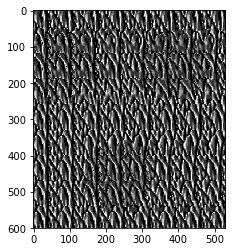

0.0683882868897


In [14]:
ca = sd1 + sd2 + sd3 + sd4
################################ Depth Estimate
depth_estimate = np.zeros([ca.shape[0],ca.shape[1]])

for x in range(ca.shape[0]):
    for y in range(ca.shape[1]):
        peak = np.abs(np.argmax(np.abs(ca[x,y]))-64)
        depth_estimate[x,y] = peak
plt.imshow(depth_estimate[0:,70:], cmap="binary")
plt.show()
dm = np.array(Image.open("dm.png").convert("L"))
corr = np.corrcoef(depth_estimate[0:,70:].flatten(),dm[0:,70:].flatten())[0,1]
print(corr)

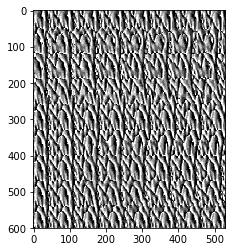

0.00867557754534


In [15]:
ca = sd2 + sd3 + sd4 + sd5
################################ Depth Estimate
depth_estimate = np.zeros([ca.shape[0],ca.shape[1]])

for x in range(ca.shape[0]):
    for y in range(ca.shape[1]):
        peak = np.abs(np.argmax(np.abs(ca[x,y]))-64)
        depth_estimate[x,y] = peak
plt.imshow(depth_estimate[0:,70:], cmap="binary")
plt.show()
dm = np.array(Image.open("dm.png").convert("L"))
corr = np.corrcoef(depth_estimate[0:,70:].flatten(),dm[0:,70:].flatten())[0,1]
print(corr)